This lab on Ridge Regression and the Lasso is a Python adaptation of p. 251-255 of "Introduction to Statistical Learning with Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. Adapted by R. Jordan Crouser at Smith College for SDS293: Machine Learning (Spring 2016).

# 6.6: Ridge Regression and the Lasso

In [95]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale 
from sklearn import cross_validation
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

We will use the ${\tt sklearn}$ package in order to perform ridge regression and
the lasso. The main functions in this package that we care about are ${\tt Ridge()}$, which can be used
to fit ridge regression models, and ${\tt Lasso()}$ which will fit lasso models. They also have cross-validated counterparts: ${\tt RidgeCV()}$ and ${\tt LassoCV()}$. We'll use these a bit later.

Before proceeding, let's first ensure that the missing values have
been removed from the data, as described in the previous lab.

In [96]:
df = pd.read_csv('Hitters.csv').dropna().drop('Player', axis=1)
df.info()
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 20 columns):
AtBat        263 non-null int64
Hits         263 non-null int64
HmRun        263 non-null int64
Runs         263 non-null int64
RBI          263 non-null int64
Walks        263 non-null int64
Years        263 non-null int64
CAtBat       263 non-null int64
CHits        263 non-null int64
CHmRun       263 non-null int64
CRuns        263 non-null int64
CRBI         263 non-null int64
CWalks       263 non-null int64
League       263 non-null object
Division     263 non-null object
PutOuts      263 non-null int64
Assists      263 non-null int64
Errors       263 non-null int64
Salary       263 non-null float64
NewLeague    263 non-null object
dtypes: float64(1), int64(16), object(3)
memory usage: 43.1+ KB


We will now perform ridge regression and the lasso in order to predict ${\tt Salary}$ on
the ${\tt Hitters}$ data. Let's set up our data:

In [97]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 19 columns):
AtBat          263 non-null float64
Hits           263 non-null float64
HmRun          263 non-null float64
Runs           263 non-null float64
RBI            263 non-null float64
Walks          263 non-null float64
Years          263 non-null float64
CAtBat         263 non-null float64
CHits          263 non-null float64
CHmRun         263 non-null float64
CRuns          263 non-null float64
CRBI           263 non-null float64
CWalks         263 non-null float64
PutOuts        263 non-null float64
Assists        263 non-null float64
Errors         263 non-null float64
League_N       263 non-null float64
Division_W     263 non-null float64
NewLeague_N    263 non-null float64
dtypes: float64(19)
memory usage: 41.1 KB


# 6.6.1 Ridge Regression
The ${\tt Ridge()}$ function has an alpha argument ($\lambda$, but with a different name!) that is used to tune the model. We'll generate an array of alpha values ranging from very big to very small, essentially
covering the full range of scenarios from the null model containing
only the intercept, to the least squares fit:

In [98]:
alphas = 10**np.linspace(10,-2,100)*0.5
alphas

array([  5.00000000e+09,   3.78231664e+09,   2.86118383e+09,
         2.16438064e+09,   1.63727458e+09,   1.23853818e+09,
         9.36908711e+08,   7.08737081e+08,   5.36133611e+08,
         4.05565415e+08,   3.06795364e+08,   2.32079442e+08,
         1.75559587e+08,   1.32804389e+08,   1.00461650e+08,
         7.59955541e+07,   5.74878498e+07,   4.34874501e+07,
         3.28966612e+07,   2.48851178e+07,   1.88246790e+07,
         1.42401793e+07,   1.07721735e+07,   8.14875417e+06,
         6.16423370e+06,   4.66301673e+06,   3.52740116e+06,
         2.66834962e+06,   2.01850863e+06,   1.52692775e+06,
         1.15506485e+06,   8.73764200e+05,   6.60970574e+05,
         5.00000000e+05,   3.78231664e+05,   2.86118383e+05,
         2.16438064e+05,   1.63727458e+05,   1.23853818e+05,
         9.36908711e+04,   7.08737081e+04,   5.36133611e+04,
         4.05565415e+04,   3.06795364e+04,   2.32079442e+04,
         1.75559587e+04,   1.32804389e+04,   1.00461650e+04,
         7.59955541e+03,

Associated with each alpha value is a vector of ridge regression coefficients, which we'll
store in a matrix ${\tt coefs}$. In this case, it is a $19 \times 100$
matrix, with 19 rows (one for each predictor) and 100
columns (one for each value of alpha). Remember that we'll want to standardize the
variables so that they are on the same scale. To do this, we can use the
${\tt normalize=True}$ parameter:

In [99]:
ridge = Ridge(normalize=True)
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    
np.shape(coefs)

(100, 19)

We expect the coefficient estimates to be much smaller, in terms of $l_2$ norm,
when a large value of alpha is used, as compared to when a small value of alpha is
used. Let's plot and find out:

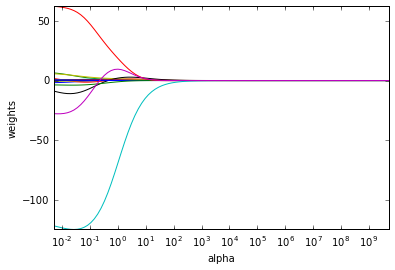

In [100]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

We now split the samples into a training set and a test set in order
to estimate the test error of ridge regression and the lasso:

In [101]:
# Use the cross-validation package to split data into training and test sets
X_train, X_test , y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.5, random_state=1)

Next we fit a ridge regression model on the training set, and evaluate
its MSE on the test set, using $\lambda = 4$:

In [102]:
ridge2 = Ridge(alpha=4, normalize=True)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred2 = ridge2.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index=X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred2))        # Calculate the test MSE

AtBat           0.098658
Hits            0.446094
HmRun           1.412107
Runs            0.660773
RBI             0.843403
Walks           1.008473
Years           2.779882
CAtBat          0.008244
CHits           0.034149
CHmRun          0.268634
CRuns           0.070407
CRBI            0.070060
CWalks          0.082795
PutOuts         0.104747
Assists        -0.003739
Errors          0.268363
League_N        4.241051
Division_W    -30.768885
NewLeague_N     4.123474
dtype: float64
106216.52238


The test MSE when alpha = 4 is 106216. Now let's see what happens if we use a huge value of alpha, say $10^{10}$:

In [103]:
ridge3 = Ridge(alpha=10**10, normalize=True)
ridge3.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred3 = ridge3.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge3.coef_, index=X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred3))        # Calculate the test MSE

AtBat          1.317464e-10
Hits           4.647486e-10
HmRun          2.079865e-09
Runs           7.726175e-10
RBI            9.390640e-10
Walks          9.769219e-10
Years          3.961442e-09
CAtBat         1.060533e-11
CHits          3.993605e-11
CHmRun         2.959428e-10
CRuns          8.245247e-11
CRBI           7.795451e-11
CWalks         9.894387e-11
PutOuts        7.268991e-11
Assists       -2.615885e-12
Errors         2.084514e-10
League_N      -2.501281e-09
Division_W    -1.549951e-08
NewLeague_N   -2.023196e-09
dtype: float64
172862.235804


This big penalty shrinks the coefficients to a very large degree, essentially reducing to a model containing just the intercept. This over-shrinking makes the model more biased, resulting in a higher MSE.

Okay, so fitting a ridge regression model with alpha = 4 leads to a much lower test
MSE than fitting a model with just an intercept. We now check whether
there is any benefit to performing ridge regression with alpha = 4 instead of
just performing least squares regression. Recall that least squares is simply
ridge regression with alpha = 0.

In [104]:
ridge2 = Ridge(alpha=0, normalize=True)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred = ridge2.predict(X_test)            # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index=X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred))         # Calculate the test MSE

AtBat           -1.821115
Hits             4.259156
HmRun           -4.773401
Runs            -0.038760
RBI              3.984578
Walks            3.470126
Years            9.498236
CAtBat          -0.605129
CHits            2.174979
CHmRun           2.979306
CRuns            0.266356
CRBI            -0.598456
CWalks           0.171383
PutOuts          0.421063
Assists          0.464379
Errors          -6.024576
League_N       133.743163
Division_W    -113.743875
NewLeague_N    -81.927763
dtype: float64
116690.468567


It looks like we are indeed improving over regular least-squares!

Instead of arbitrarily choosing alpha $ = 4$, it would be better to
use cross-validation to choose the tuning parameter alpha. We can do this using
the cross-validated ridge regression function, ${\tt RidgeCV()}$. By default, the function
performs generalized cross-validation (an efficient form of LOOCV), though this can be changed using the
argument ${\tt cv}$.

In [105]:
ridgecv = RidgeCV(alphas=alphas, scoring='mean_squared_error', normalize=True)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

0.57487849769886779

Therefore, we see that the value of alpha that results in the smallest cross-validation
error is 0.57. What is the test MSE associated with this value of
alpha?

In [106]:
ridge4 = Ridge(alpha=ridgecv.alpha_, normalize=True)
ridge4.fit(X_train, y_train)
mean_squared_error(y_test, ridge4.predict(X_test))

99825.648962927298

This represents a further improvement over the test MSE that we got using
alpha $ = 4$. Finally, we refit our ridge regression model on the full data set,
using the value of alpha chosen by cross-validation, and examine the coefficient
estimates.

In [107]:
ridge4.fit(X, y)
pd.Series(ridge4.coef_, index=X.columns)

AtBat           0.055838
Hits            0.934879
HmRun           0.369048
Runs            1.092480
RBI             0.878259
Walks           1.717770
Years           0.783515
CAtBat          0.011318
CHits           0.061101
CHmRun          0.428333
CRuns           0.121418
CRBI            0.129351
CWalks          0.041990
PutOuts         0.179957
Assists         0.035737
Errors         -1.597699
League_N       24.774519
Division_W    -85.948661
NewLeague_N     8.336918
dtype: float64

As expected, none of the coefficients are exactly zero - ridge regression does not
perform variable selection!

# 6.6.2 The Lasso
We saw that ridge regression with a wise choice of alpha can outperform least
squares as well as the null model on the Hitters data set. We now ask
whether the lasso can yield either a more accurate or a more interpretable
model than ridge regression. In order to fit a lasso model, we'll
use the ${\tt Lasso()}$ function; however, this time we'll need to include the argument ${\tt max_iter=10000}$.
Other than that change, we proceed just as we did in fitting a ridge model:

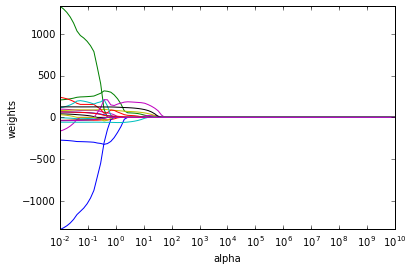

In [109]:
lasso = Lasso(max_iter=10000, normalize=True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

Notice that in the coefficient plot that depending on the choice of tuning
parameter, some of the coefficients are exactly equal to zero. We now
perform 10-fold cross-validation to choose the best alpha, refit the model, and compute the associated test error:

In [110]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test))



104960.65853895503

This is substantially lower than the test set MSE of the null model and of
least squares, and only a little worse than the test MSE of ridge regression with alpha
chosen by cross-validation.

However, the lasso has a substantial advantage over ridge regression in
that the resulting coefficient estimates are sparse. Here we see that 13 of
the 19 coefficient estimates are exactly zero:

In [111]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

AtBat           0.000000
Hits            1.082446
HmRun           0.000000
Runs            0.000000
RBI             0.000000
Walks           2.906388
Years           0.000000
CAtBat          0.000000
CHits           0.000000
CHmRun          0.219367
CRuns           0.000000
CRBI            0.513975
CWalks          0.000000
PutOuts         0.368401
Assists        -0.000000
Errors         -0.000000
League_N        0.000000
Division_W    -89.064338
NewLeague_N     0.000000
dtype: float64

To get credit for this lab, post your responses to the following questions:
 - How do ridge regression and the lasso improve on simple least squares?
 - In what cases would you expect ridge regression outperform the lasso, and vice versa?
 - What was the most confusing part of today's class?
 
to Piazza: https://piazza.com/class/igwiv4w3ctb6rg?cid=38